### Performing Regime Analysis on SPX/VIX Data
##### Jack Tobin
##### 29 September 2021

First we need to load in the modules we've defined in regimes.py in our working directory. Then we'll download the data and perform a basic K-Means clustering on the VIX data to arrige out our final dataset.

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# this is from our script of custom functions in working dir
from regimes import download_data, regime_clustering

# download data
all_data = download_data()

# use k-means to cluster periods into two volatility regimes
regimes = regime_clustering(all_data['VIX'])

# concat onto all_data
all_data.reset_index(inplace=True, drop=True)
all_data['Regime'] = regimes['Label']
all_data.set_index('Date', drop=True, inplace=True)

all_data.head()

,SPX,VIX,Regime
Date,,,
1990-01-02,0.017799,17.240000,Low Vol
1990-01-03,-0.002586,18.190001,Low Vol
1990-01-04,-0.008613,19.219999,Low Vol
1990-01-05,-0.009756,20.110001,Low Vol
1990-01-08,0.004514,20.260000,Low Vol


Next we'll produce a handful of visualizations to show what the data look like

<AxesSubplot:xlabel='SPX', ylabel='Count'>

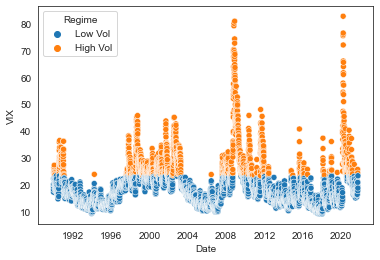

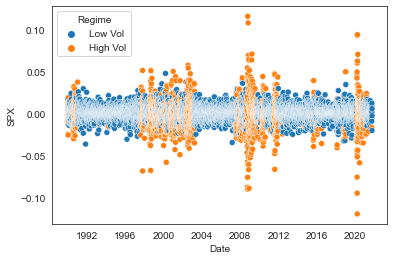

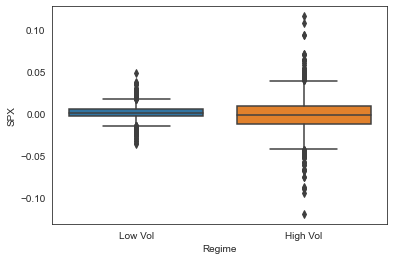

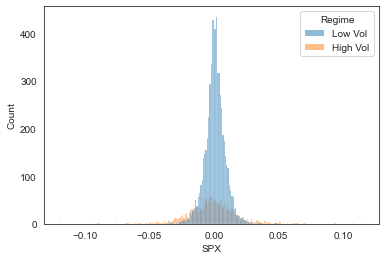

In [77]:
# make plot of VIX delineated by regime
fig, ax = plt.subplots(1)
sns.scatterplot(data=all_data, x='Date', y='VIX', hue='Regime', ax=ax)

# make plot of daily returns delineated by regime
fig, ax = plt.subplots(1)
sns.scatterplot(data=all_data, x='Date', y='SPX', hue='Regime', ax=ax)

# box and whisker plot by regime
fig, ax = plt.subplots()
sns.boxplot(data=all_data, x='Regime', y='SPX', ax=ax)

# make histograms by regime
fig, ax = plt.subplots(1)
sns.histplot(data=all_data, x='SPX', hue='Regime', ax=ax)

These plots help us visualize how the market behaves during the two volatility regimes: in high volatility periods, the daily returns are highly dispersed with a lower average return. We also observe a strong degree of volatility clustering where high volatility begets high volatility.

Next we'll compute some statistics to use as hyperparamters in our monte carlo simulation engine. These will characterize the distribution of returns in low-vol/high-vol periods as well as the relative frequency of each and the probability of moving from one regime to another.

First: Daily/Annual Returns and Volatilities

In [78]:
# returns and standard deviations
ret = all_data['SPX'].mean()
vol = all_data['SPX'].std()
ann_ret = ret * 252
ann_vol = vol * np.sqrt(252)

print('Average Daily Return: %s' % str(round(ret * 100, 2)) + '%')
print('Average Daily Volatility: %s' % str(round(vol * 100, 2)) + '%')
print('Average Annual Return: %s' % str(round(ann_ret * 100, 2)) + '%')
print('Average Annual Volatility: %s' % str(round(ann_vol * 100, 2)) + '%')

Average Daily Return: 0.04%
Average Daily Volatility: 1.14%
Average Annual Return: 9.49%
Average Annual Volatility: 18.17%


Next: Daily Returns and Volatilities by Regime

In [79]:
# stats by regime - non annualized since relative diffs are used for sim
rets = all_data.groupby('Regime')['SPX'].mean()
vols = all_data.groupby('Regime')['SPX'].std()

print(rets)
print(vols)

Regime
High Vol   -0.001454
Low Vol     0.000935
Name: SPX, dtype: float64
Regime
High Vol    0.019189
Low Vol     0.007574
Name: SPX, dtype: float64


This says that in periods of high volatility the average daily return is -0.14% with 1.9% volatility. In periods of low volatility the average daily return is 0.09% with 0.76% volatility.

Next we'll compute the 'relative differences' between the high volatility and low volatility regimes in terms of location (difference between regime means and central mean) and scale (multiple between regime vols and central vol). This is so when we construct the Markov chain we can instruct the model to generate two sub-distributions based on these transformations.

In [80]:
# the relative differences and multiples 
ret_diff = rets - ret
vol_mult = vols / vol

print(ret_diff)
print(vol_mult)

Regime
High Vol   -0.001831
Low Vol     0.000558
Name: SPX, dtype: float64
Regime
High Vol    1.676578
Low Vol     0.661775
Name: SPX, dtype: float64


This says that in periods of high volatility returns are 0.18% lower than average with 1.67x greater volatility. In periods of low volatility, returns are 0.006% greater than average with 0.66x the volatility.

Next we'll compute some basic probabilities of high vol and low vol regimes.

In [81]:
# probabilities
prob_high = sum(regimes['Number']) / len(regimes['Number'])
prob_low = 1 - prob_high

print('Aggregate Probability of High Volatility: %s' % str(round(prob_high * 100, 2)) + '%')
print('Aggregate Probability of Low Volatility: %s' % str(round(prob_low * 100, 2)) + '%')

Aggregate Probability of High Volatility: 23.37%
Aggregate Probability of Low Volatility: 76.63%


This says that we exist in a period of low volatility 76% of the time and a period of high volatility in the remaining 23% of observations. Any any given time, we're 23% likely to be in a period of high volatility.

Next we'll compute conditional probabilities to describe the likelihood of moving from one regime to the other. The probability of moving to high vol from low vol will be the count of high vol where the previous regime was low divided by the total number of low vol periods, the probability of moving to low vol from high vol will be the count of low vol where the previous regime was high vol divided by the total number of high vol periods.

In [82]:
p_l_l = sum(np.logical_and(regimes['Number'].shift() == 0, regimes['Number'] == 0)) / sum(regimes['Number'] == 0)
p_l_h = sum(np.logical_and(regimes['Number'].shift() == 0, regimes['Number'] == 1)) / sum(regimes['Number'] == 0)
p_h_h = sum(np.logical_and(regimes['Number'].shift() == 1, regimes['Number'] == 1)) / sum(regimes['Number'] == 1)
p_h_l = sum(np.logical_and(regimes['Number'].shift() == 1, regimes['Number'] == 0)) / sum(regimes['Number'] == 1)

print('Prob of Staying in LV: %s' % str(round(p_l_l * 100, 2)) + '%')
print('Prob of Moving from LV to HV: %s' % str(round(p_l_h * 100, 2)) + '%')
print('Prob of Staying in HV: %s' % str(round(p_h_h * 100, 2)) + '%')
print('Prob of Moving from HV to LV: %s' % str(round(p_h_l * 100, 2)) + '%')

Prob of Staying in LV: 97.21%
Prob of Moving from LV to HV: 2.77%
Prob of Staying in HV: 90.91%
Prob of Moving from HV to LV: 9.09%


This states that when we are currently in a LV period, our probability of remaining in LV is 97.2% and our probability of moving to a HV period is 2.8%. When we're in a HV period, our probability of remaining in HV is 90.9% and our probability of moving from HV to LV is 9.1%.

This also conveys the 'stickyness' of volatility periods. We're much more likely to remain in our current regime than move to the next one. However, once we move to the next regime, we're a bit stuck there due to the tendency of volatility to cluster.